In [3]:
import sys
sys.path.append('../')
sys.path.append('../../')
from DEDi import ode_find as ode
from DEDi.ODE.PolyLib import PolyFunc
import numpy as np
import matplotlib.pyplot as plt

### Van Der Pol Oscillator
$\mu = 2$

\begin{align}
    \frac{dx}{dt} &= y \\
    \frac{dy}{dt} &= \mu(1-x^2)y - x
\end{align}

Blocking out data for t in (4.0,6.0)
Size = (250, 2), dt = 0.04


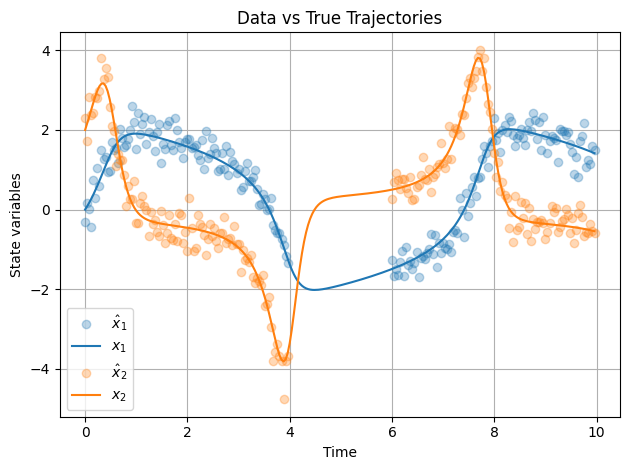

In [4]:
Data = np.load('../_ODEData/VDPData.npz')
x_data_true_full = Data['x']
t_full = Data['t']

np.random.seed(123)
subsample = 40
x_data_true = x_data_true_full[::subsample]
t = t_full[::subsample]


noise_p, stand_dev = .2, np.std(x_data_true, axis = 0)
x_data = x_data_true + np.random.normal(0,stand_dev*noise_p, size = x_data_true.shape)

#Define a state mask
state_mask = np.ones_like(x_data, dtype=bool)
N_t = len(t)
t0_miss, tf_miss = int(.4*N_t),int(.6*N_t)
print(f"Blocking out data for t in ({t[t0_miss]},{t[tf_miss]})")
state_mask[t0_miss:tf_miss] = False
x_data = x_data*state_mask #Make sure to remove before putting it into optimization, simulates missing data

# Define validation mask, standard is every third time (33% of data)
validation_mask = np.ones_like(x_data, dtype=bool)
validation_mask[2::3] = False


print(f'Size = {np.shape(x_data)}, dt = {t[1]-t[0]}')
from DEDi.plot_trajectories import plot_trajectory
x_data_for_plotting = x_data.copy()
x_data_for_plotting[np.where(x_data_for_plotting == 0)] = np.nan #Otherwise it will show up as zeros, which is wrong
plot_trajectory(t,x_data_for_plotting,x_data_true)

In [5]:
Library = PolyFunc(num_vars=x_data.shape[1],degree=3)
print(Library)

# Initialize Library & Model Discovery
# lambdas,Rs  = 10**(np.linspace(-3, 3, 7)),10**(np.linspace(-4, 0, 5))  #Parameter's used in paper, better to try a simple run first 
lambdas = [10**(-2)]
Rs = [10**(-4)]

discoverode = ode(x_data,Library,[t[0],t[-1]],state_mask=state_mask, validation_mask=validation_mask)
discoverode.FindBestModel(lambdas, Rs)

['x_1', 'x_2', 'x_1**2', 'x_1*x_2', 'x_2**2', 'x_1**3', 'x_1**2*x_2', 'x_1*x_2**2', 'x_2**3']
Setting up Sparse Hessian
Colors Needed = 25
[INFO] Validation mask includes entries with missing data. These will be ignored during validation error computation.
[Failed to Converged] Iter 500: ||grad|| = 9.24e-01
[Failed to Converged] Iter 500: ||grad|| = 8.59e-01
lam = 1.00e-02, R = 1.00e-04, nonzero = 4, val_error = 1.0004e-01,BIC = -2.84e+02, model_error = 2.1296e-06, state_error = 8.0831e-02


In [6]:
models = discoverode.PrintModels(N_best= 1) #Increase cutoff to see other models found

<IPython.core.display.Latex object>

L2 Error = 1.654e-02, LInf Error = 2.208e-02, TPR = 100%


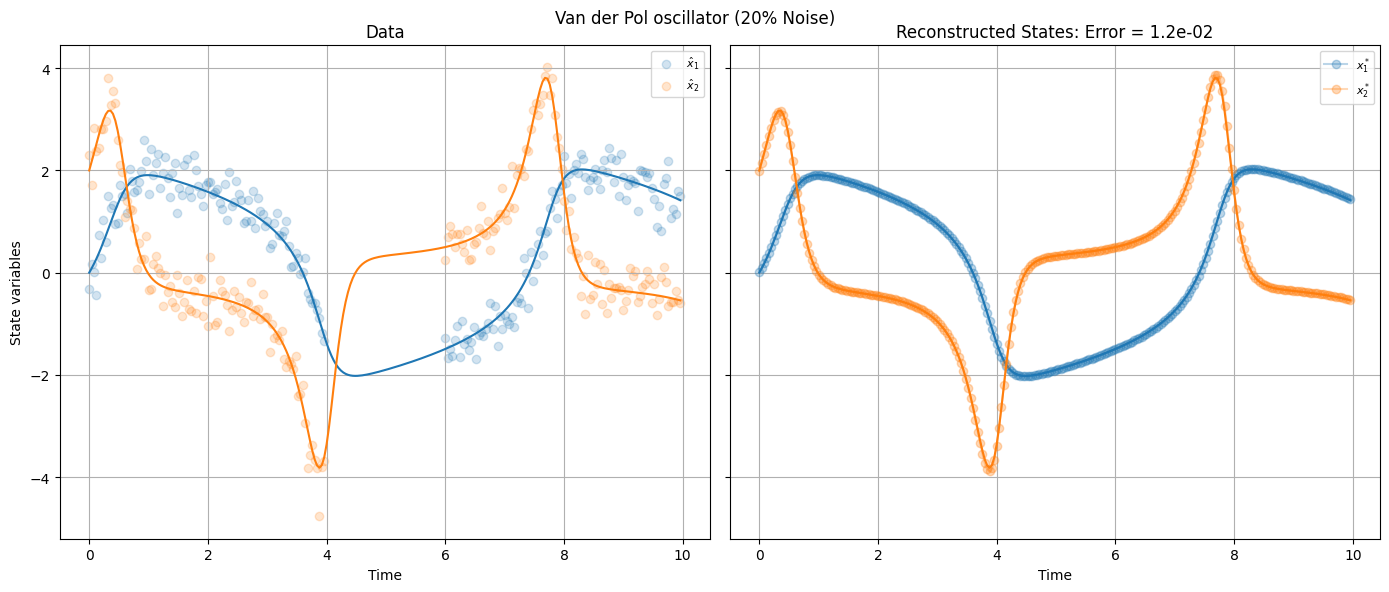

In [7]:
opt_params, opt_NL_params, opt_states = discoverode.best_model()

from _ODEData.Functions.ODEFuncs import generate_coeff_matrix, getvdpcoeffs, Report_Errors
true_coeffs = generate_coeff_matrix(Library, getvdpcoeffs())
L2_error, LInf_error, true_positivity_ratio = Report_Errors(true_coeffs, opt_params)
print(f"L2 Error = {L2_error:.3e}, LInf Error = {LInf_error:.3e}, TPR = {int(true_positivity_ratio*100)}%")

from DEDi.plot_trajectories import plot_solution
plot_solution(t,x_data_for_plotting,opt_states,x_data_true, title= f"Van der Pol oscillator ({int(noise_p*100)}% Noise)")